In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from math import floor, ceil
import seaborn as sns

In [136]:
data = pd.read_csv('diabetes.csv')
# Nowy plik na rozmyte od 0

In [137]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [138]:
cleared_data = data[data['Glucose'] != 0]
cleared_data = cleared_data[cleared_data['BloodPressure'] != 0]
cleared_data = cleared_data[cleared_data['SkinThickness'] != 0]
cleared_data = cleared_data[cleared_data['Insulin'] != 0]
cleared_data = cleared_data[cleared_data['BMI'] != 0]
cleared_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [156]:
# Klasa statyczna zawierająca metody przydatne to przetwarzania danych
class ProcessingData:

    # metoda tasująca wiersze pd.DataFrame
    @staticmethod
    def shuffle(df: pd.DataFrame) -> pd.DataFrame:
        """
        Receives a DataFrame, randomly shuffles it and returns a shuffled version.
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        for idx in range(len(df) - 1, 0, -1):
            rand_idx = random.randint(0, idx)
            df.iloc[idx], df.iloc[rand_idx] = df.iloc[rand_idx], df.iloc[idx]
        return df.reset_index(drop=True)

    # metoda normalizująca kolumny pd.DataFrame za pomocą normalizacji z użyciem odchylenia standardowego
    @staticmethod
    def normalize_std(df: pd.DataFrame, label: str) -> pd.DataFrame:
        """
        Receives a DataFrame and a class label to skip during normalization, normalizes data using min-max normalization and returns the normalized version.
        :param label: str
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        normalized = df.drop(labels=label, axis=1)
        normalized = (normalized-normalized.mean())/(normalized.std())
        return normalized.join(df[label])

    # metoda normalizująca kolumny pd.DataFrame za pomocą normalizacji minmax
    @staticmethod
    def normalize_minmax(df: pd.DataFrame, label: str) -> pd.DataFrame:
        """
        Receives a DataFrame and a class label to skip during normalization, normalizes data using min-max normalization and returns the normalized version.
        :param label: str
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        normalized = df.drop(labels=label, axis=1)
        normalized = (normalized-normalized.min())/(normalized.max()-normalized.min())
        return normalized.join(df[label])

    # metoda dzieląca pd.DataFrame na zbiór treningowy oraz walidacyjny
    @staticmethod
    def split(df: pd.DataFrame, ratio: float) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Receives a DataFrame and returns two dataframes, split into training and validation DataFrames.
        :param df: pd.DataFrame
        :param ratio: float
        :return training_df, validation_df: tuple[pd.DataFrame, pd.DataFrame]
        """
        cutoff = int(len(df) * ratio)
        return df[:cutoff].reset_index(drop=True), df[cutoff:].reset_index(drop=True)

In [157]:
shuffled_data = ProcessingData.shuffle(data)
training_data, _ = ProcessingData.split(shuffled_data, 0.7)

In [163]:
class Fuzzy:
    def __init__(self):
        # słownik słowników rozmycia dla każdej kolumny
        self.antecedents: dict[str: dict[str: tuple[float]]] = {}
        # lista zawierająca nazwę etykiety klasy oraz słowników z jej rozmyciem
        self.consequent: dict[str: dict[str: tuple[float]]] = {}
        # lista słowników; każda reguła to jeden słownik
        self.rules: list[dict[str: str]] = []

    # metoda pozwalająca na dodanie poprzednika
    def add_antecedent(self, parameter: str, linguistic_value: str, *args) -> None:
        if parameter not in self.antecedents:
            self.antecedents[parameter] = {}
        self.antecedents[parameter][linguistic_value] = args

    # metoda pozwalająca na dodanie konsekwencji
    def add_consequent(self, parameter: str, linguistic_value: str, *args) -> None:
        if parameter not in self.consequent:
            self.consequent[parameter] = {}
        self.consequent[parameter][linguistic_value] = args

    # metoda pozwalająca dodać regułę
    def add_rule(self, rule: dict[str: str]) -> None:
        assert set(rule.keys()) == set.union(set(self.antecedents.keys()), set(self.consequent.keys())), print("Nieprawidłowa liczba kategorii w regule.")
        self.rules.append(rule)

    # metoda obliczająca przynależność dla funkcji typu trójkąt
    @staticmethod
    def triangular_function(n: float, a: float, b: float, c: float) -> float:
        assert a <= b <= c, print("Nieprawidłowe wartości")
        if n == a == b or n == b == c:
            return 1
        if n <= a:
            return 0
        if a < n < b:
            return (n - a) / (b - a)
        if n == b:
            return 1
        if b < n < c:
            return (c - n) / (c - b)
        if n >= c:
            return 0

    # metoda obliczająca przynależność dla funkcji typu trapez
    @staticmethod
    def trapezoidal_function(n: float, a: float, b: float, c: float, d: float) -> float:
        assert a <= b <= c <= d, print("Nieprawidłowe wartości")
        if c == d and n >= d:
            return 1
        if a == b and n <= a:
            return 1
        if n <= a:
            return 0
        if a < n < b:
            return (n - a) / (b - a)
        if b <= n <= c:
            return 1
        if c < n < d:
            return (d - n) / (d - c)
        if n >= d:
            return 0

    # metoda wywołująca funkcję przynależności
    def membership_function(self, n: float, *args) -> float:
        assert len(args) in (3, 4), print("Nieprawidłowa liczba argumentów")
        if len(args) == 3:
            return self.triangular_function(n, *args)
        else:
            return self.trapezoidal_function(n, *args)

    # metoda rozmywająca dane wejściowe
    def fuzzify(self, column: str, n: float) -> dict[str, float]:
        return {antecedent: self.membership_function(n, *self.antecedents[column][antecedent]) for antecedent in self.antecedents[column].keys()}

    # metoda obliczająca stopień spełnienia danej zasady
    @staticmethod
    def rule_fulfillment(rule: dict[str: str], fuzzy_values: dict[str: dict[str: float]]) -> tuple[str, float]:
        label = list(rule.keys())[-1]
        minimum = float('inf')
        # dla każdej wartości w danej zasadzie
        for name, linguistic_value in list(rule.items())[:-1]:
            maximum = float('-inf')
            # jeśli mamy wartości rozdzielone 'or', to bierzemy ich maksimum
            for lvs in linguistic_value.split(' | '):
                maximum = max(fuzzy_values[name][lvs], maximum)
            # bierzemy minimum stopni spełnienia wartości danej zasady
            minimum = min(minimum, maximum)
        return rule[label], minimum

    # metoda obliczająca powierzchnię danego wyniku
    @staticmethod
    def area(a: float, c: float) -> float:
        return (c - a) / 2

    # metoda środka ciężkości
    @staticmethod
    def cog(a: float, b: float, c: float) -> float:
        return (a + b + c) / 3

    # metoda agregująca, wyostrzająca wartość końcową za pomocą metody środka ciężkości
    def aggregate(self, label: str, outputs: defaultdict) -> float:
        # licznik i mianownik dla funkcji agregującej
        counter = []
        denominator = []
        # obliczanie powierzchni oraz środka ciężkości każdej etykiety funkcji przynależności
        for name, membership in outputs.items():
            if not membership:
                continue
            a, b, c = self.consequent[label][name]
            area = self.area(a, c)
            cog = self.cog(a, b, c)
            counter.append(membership * area * cog)
            denominator.append(membership * area)
        return round(sum(counter) / sum(denominator), 3)

    # metoda przewidująca etykietę klasy
    def compute(self, sample: pd.Series) -> tuple[str, float]:
        # rozmycie próbki
        fuzzy_values = {column: self.fuzzify(column, sample[column]) for column in self.antecedents.keys()}

        # obliczenie stopnia spełnienia zasad
        fulfillments = [self.rule_fulfillment(rule, fuzzy_values) for rule in self.rules]

        # wybranie maksymalnego spełnienia reguły dla danych wartości
        outputs: defaultdict = defaultdict(lambda: 0)
        for linguistic_value, fulfillment in fulfillments:
            outputs[linguistic_value] = max(outputs[linguistic_value], fulfillment)
        outputs = dict(outputs)
        label = list(self.consequent.keys())[0]
        # wybór przewidzianej etykiety klasy — w przypadku remisu dla dwóch etykiet wybieramy chorobę
        output_names = sorted(outputs.keys(), key=lambda x: (-1 * outputs[x], x), reverse=True)
        # output_names = sorted(outputs.keys(), key=lambda x: (outputs[x], x))
        # print(sample['Outcome'], self.aggregate(label, outputs), outputs)
        return output_names[-1], self.aggregate(label, outputs)

    # metoda pomocnicza wyświetlająca wykres rozmycia cechy
    def view(self, parameter: str) -> None:
        # lista kolorów do wykresów
        colors: dict[int: tuple] = {2: ('#00b100', '#ff5c38'),
                                    3: ('#00b100', '#d5c731', '#ff5c38'),
                                    4: ('#00b100', '#adcd27', '#f1b438', '#ff5c38'),
                                    5: ('#00b100', '#93cb20', '#d5c731', '#f9a539', '#ff5c38')}
        # globalne parametry dla wykresów matplotlib.pyplot
        plt.rcParams["figure.figsize"] = (14, 8)
        if parameter in self.consequent.keys():
            source = self.consequent[parameter]
        else:
            source = self.antecedents[parameter]

        # stworzenie dziedziny
        minimum: int = floor(list(source.values())[0][0])
        maximum: int = ceil(list(source.values())[-1][-1])
        x = np.linspace(minimum, maximum, num=(maximum - minimum) * 100 + 1)
        # stworzenie wykresów funkcji przynależności
        for k, v, color in zip(source.keys(), source.values(), colors[len(source.keys())]):
            y = np.array([self.membership_function(i, *v) for i in x])
            plt.plot(x, y, color, label=k)

        # nadanie parametrów wykresu
        plt.rc('font', size=16)
        plt.rc('axes', titlesize=14)
        plt.rc('axes', labelsize=14)
        plt.rc('xtick', labelsize=14)
        plt.rc('ytick', labelsize=14)
        plt.rc('legend', fontsize=14)
        plt.rc('figure', titlesize=16)
        plt.title(parameter)
        plt.xlabel('Membership')
        plt.ylabel(parameter)
        plt.legend(loc="upper right")
        plt.ylim(0, 1)
        plt.show()

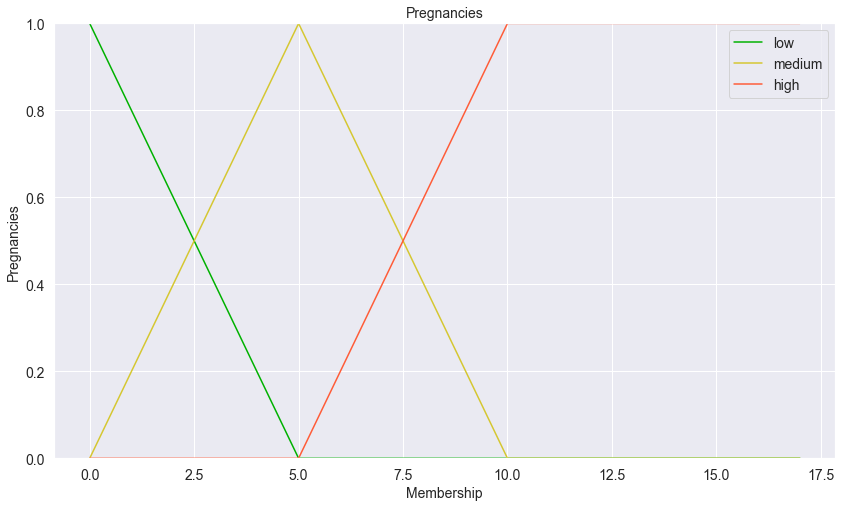

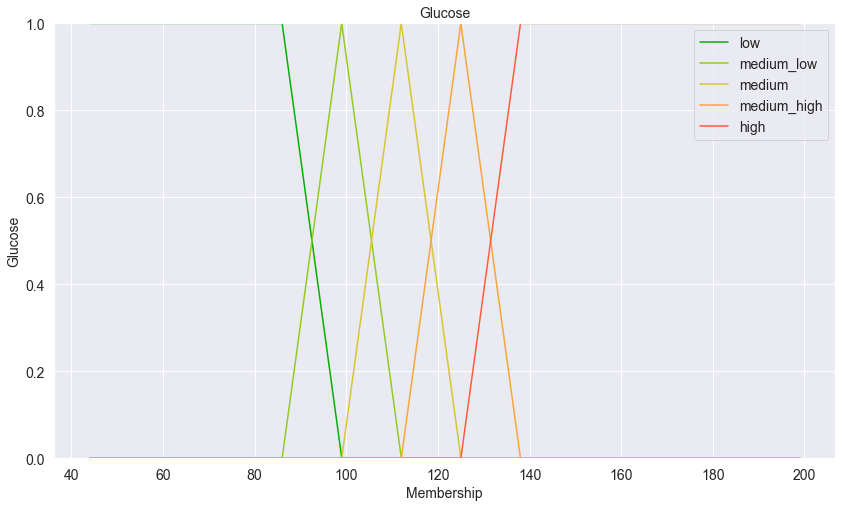

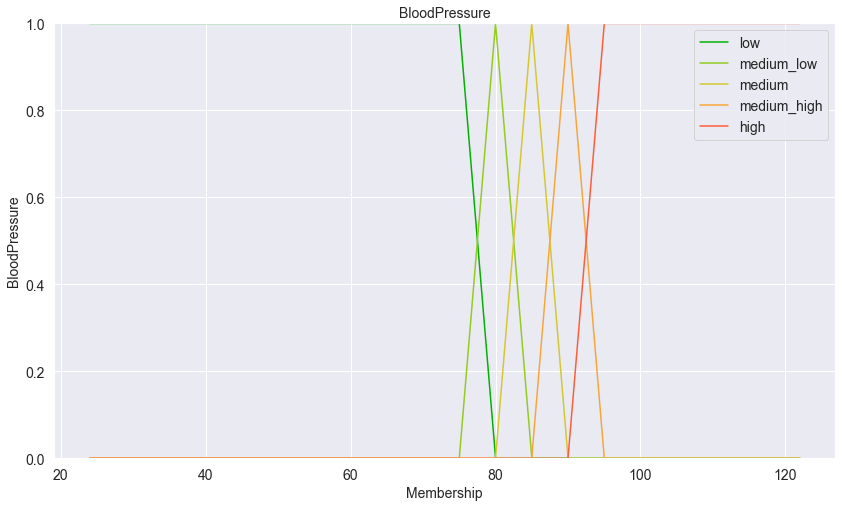

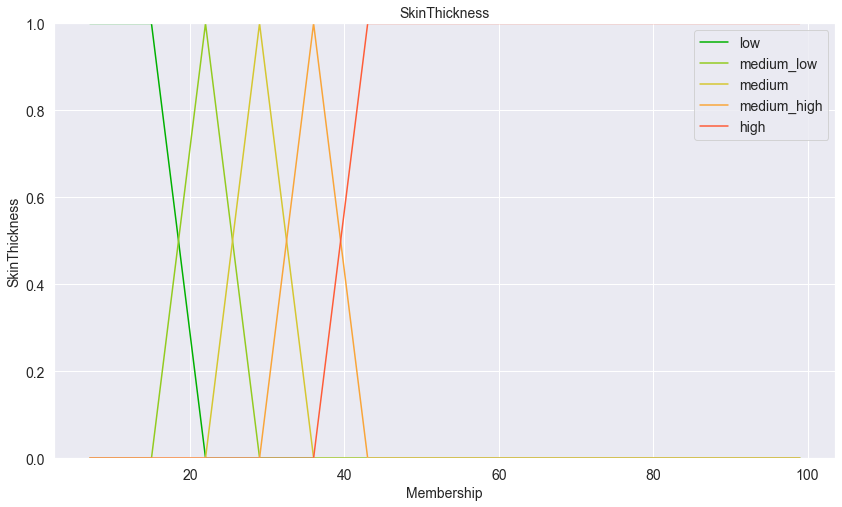

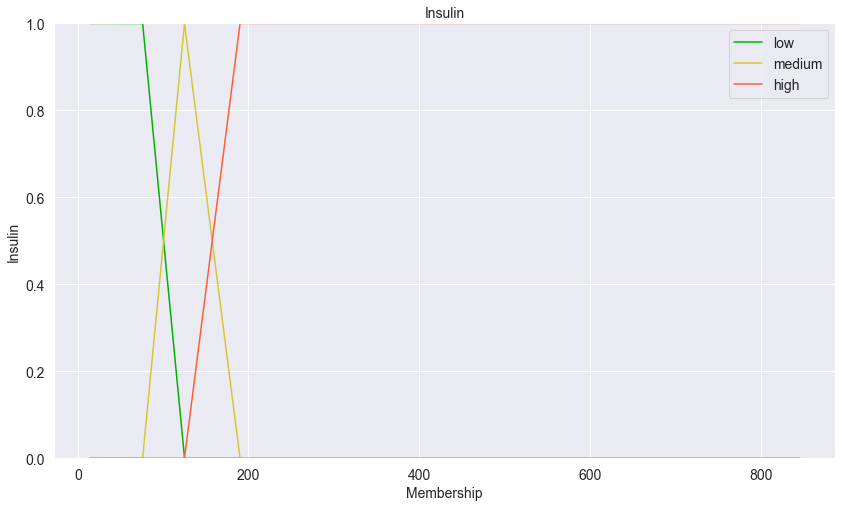

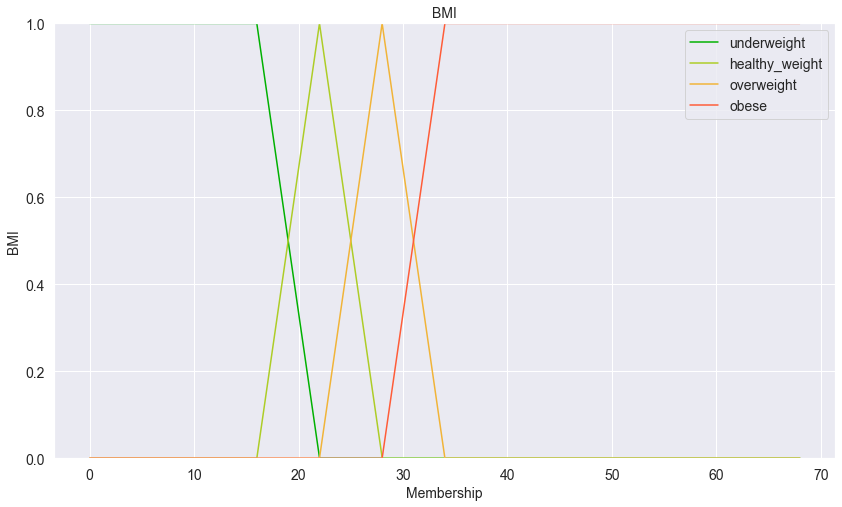

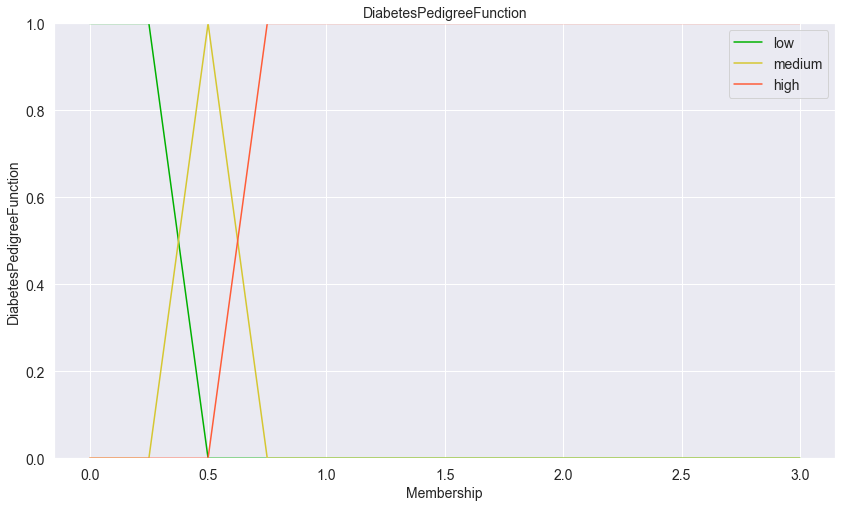

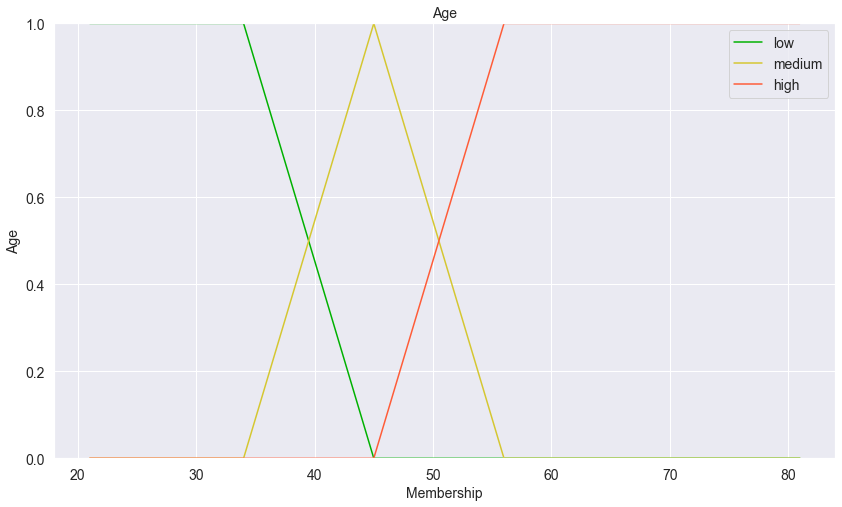

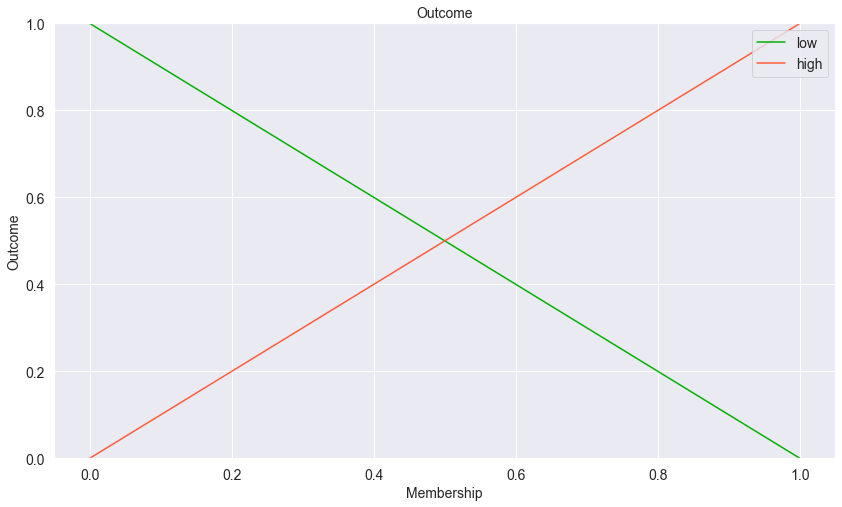

In [164]:
# Dodawanie poprzedników i konsekwencji
fuzzy = Fuzzy()

fuzzy.add_antecedent('Pregnancies', 'low', 0, 0, 5)
fuzzy.add_antecedent('Pregnancies', 'medium', 0, 5, 10)
fuzzy.add_antecedent('Pregnancies', 'high', 5, 10, 17, 17)

fuzzy.add_antecedent('Glucose', 'low', 44, 44, 86, 99)
fuzzy.add_antecedent('Glucose', 'medium_low', 86, 99, 112)
fuzzy.add_antecedent('Glucose', 'medium', 99, 112, 125)
fuzzy.add_antecedent('Glucose', 'medium_high', 112, 125, 138)
fuzzy.add_antecedent('Glucose', 'high', 125, 138, 199, 199)

fuzzy.add_antecedent('BloodPressure', 'low', 24, 24, 75, 80)
fuzzy.add_antecedent('BloodPressure', 'medium_low', 75, 80, 85)
fuzzy.add_antecedent('BloodPressure', 'medium', 80, 85, 90)
fuzzy.add_antecedent('BloodPressure', 'medium_high', 85, 90, 95)
fuzzy.add_antecedent('BloodPressure', 'high', 90, 95, 122, 122)

fuzzy.add_antecedent('SkinThickness', 'low', 7, 7, 15, 22)
fuzzy.add_antecedent('SkinThickness', 'medium_low', 15, 22, 29)
fuzzy.add_antecedent('SkinThickness', 'medium', 22, 29, 36)
fuzzy.add_antecedent('SkinThickness', 'medium_high', 29, 36, 43)
fuzzy.add_antecedent('SkinThickness', 'high', 36, 43, 99, 99)

fuzzy.add_antecedent('Insulin', 'low', 14, 14, 76, 125)
fuzzy.add_antecedent('Insulin', 'medium', 76, 125, 190)
fuzzy.add_antecedent('Insulin', 'high', 125, 190, 846, 846)

fuzzy.add_antecedent('BMI', 'underweight', 0, 0, 16, 22)
fuzzy.add_antecedent('BMI', 'healthy_weight', 16, 22, 28)
fuzzy.add_antecedent('BMI', 'overweight', 22, 28, 34)
fuzzy.add_antecedent('BMI', 'obese', 28, 34, 67.1, 67.1)

fuzzy.add_antecedent('DiabetesPedigreeFunction', 'low', 0, 0, 0.25, 0.5)
fuzzy.add_antecedent('DiabetesPedigreeFunction', 'medium', 0.25, 0.5, 0.75)
fuzzy.add_antecedent('DiabetesPedigreeFunction', 'high', 0.5, 0.75, 2.42, 2.42)

fuzzy.add_antecedent('Age', 'low', 21, 21, 34, 45)
fuzzy.add_antecedent('Age', 'medium', 34, 45, 56)
fuzzy.add_antecedent('Age', 'high', 45, 56, 81, 81)

for elem in fuzzy.antecedents:
    fuzzy.view(elem)

fuzzy.add_consequent('Outcome', 'low', 0, 0, 1)
fuzzy.add_consequent('Outcome', 'high', 0, 1, 1)
fuzzy.view('Outcome')

In [160]:
# Dodawanie reguł
# Większość niskich
# Same niskie (1) 1
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
# Pojedyncze wysokie (8) 9
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Pary Pregnancies (7) 16
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Pary Glucose (6) 22
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Pary BloodPressure (5) 27
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Pary SkinThickness (4) 31
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Pary Insulin (3) 34
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Pary BMI (2) 36
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Pary DiabetesPedigreeFunction (1) 37
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Pregnancies i Glucose (6) 43
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Pregnancies i BloodPressure (5) 48
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Pregnancies i SkinThickness (4) 52
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Pregnancies i Insulin (3) 55
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Pregnancies i BMI (2) 57
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Pregnancies i DiabetesPedigreeFunction (1) 58
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Glucose i BloodPressure (5) 63
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Glucose i SkinThickness (4) 67
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Glucose i Insulin (3) 70
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Glucose i BMI (2) 72
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Glucose i DiabetesPedigreeFunction (1) 73
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki BloodPressure i SkinThickness (4) 77
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki BloodPressure i Insulin (3) 80
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki BloodPressure i BMI (2) 82
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki BloodPressure i DiabetesPedigreeFunction (1) 83
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki SkinThickness i Insulin (3) 86
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki SkinThickness i BMI (2) 88
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki SkinThickness i DiabetesPedigreeFunction (1) 89
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Insulin i BMI (2) 91
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'low'})
# Trójki Insulin i DiabetesPedigreeFunction (1) 92
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'low'})
# Trójki BMI i DiabetesPedigreeFunction (1) 93
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'low'})

# 4 wysokie, 4 niskie
# Czwórki Pregnancies i Glucose i BloodPressure (5) 98
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i Glucose i SkinThickness (4) 102
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i Glucose i Insulin (3) 105
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i Glucose i BMI (2) 107
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i Glucose i DiabetesPedigreeFunction (1) 10
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i BloodPressure i SkinThickness (4) 112
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i BloodPressure i Insulin (3) 115
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i BloodPressure i BMI (2) 117
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i BloodPressure i DiabetesPedigreeFunction (1) 118
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i SkinThickness i Insulin (3) 121
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i SkinThickness i BMI (2) 123
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i SkinThickness i DiabetesPedigreeFunction (1) 124
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i Insulin i BMI (2) 126
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i Insulin i DiabetesPedigreeFunction (1) 127
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Pregnancies i BMI i DiabetesPedigreeFunction (1) 128
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})

# Czwórki Glucose i BloodPressure i SkinThickness (4) 132
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Glucose i BloodPressure i Insulin (3) 135
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Glucose i BloodPressure i BMI (2) 137
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Glucose i BloodPressure i DiabetesPedigreeFunction (1) 138
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Glucose i SkinThickness i Insulin (3) 141
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Glucose i SkinThickness i BMI (2) 143
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Glucose i SkinThickness i DiabetesPedigreeFunction (1) 144
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Glucose i Insulin i BMI (2) 146
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Glucose i Insulin i DiabetesPedigreeFunction (1) 147
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki Glucose i BMI i DiabetesPedigreeFunction (1) 148
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})

# Czwórki BloodPressure i SkinThickness i Insulin (3) 151
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki BloodPressure i SkinThickness i BMI (2) 153
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki BloodPressure i SkinThickness i DiabetesPedigreeFunction (1) 154
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki BloodPressure i Insulin i BMI (2) 156
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki BloodPressure i Insulin i DiabetesPedigreeFunction (1) 157
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki BloodPressure i BMI i DiabetesPedigreeFunction (1) 158
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})

# Czwórki SkinThickness i Insulin i BMI (2) 160
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki SkinThickness i Insulin i DiabetesPedigreeFunction (1) 161
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'underweight | healthy_weight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Czwórki SkinThickness i BMI i DiabetesPedigreeFunction (1) 162
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})

# Czwórki Insulin i BMI i DiabetesPedigreeFunction (1) 163
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})


# Większość niskich
# Same niskie (1) 164
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Pojedyncze niskie (8) 172
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Pary Pregnancies (7) 179
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Pary Glucose (6) 185
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Pary BloodPressure (5) 190
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Pary SkinThickness (4) 194
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Pary Insulin (3) 197
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Pary BMI (2) 199
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Pary DiabetesPedigreeFunction (1) 200
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Pregnancies i Glucose (6) 206
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Pregnancies i BloodPressure (5) 211
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Pregnancies i SkinThickness (4) 215
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Pregnancies i Insulin (3) 218
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Pregnancies i BMI (2) 220
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Pregnancies i DiabetesPedigreeFunction (1) 221
fuzzy.add_rule({'Pregnancies': 'low | medium',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Glucose i BloodPressure (5) 226
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Glucose i SkinThickness (4) 230
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Glucose i Insulin (3) 233
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Glucose i BMI (2) 235
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Glucose i DiabetesPedigreeFunction (1) 236
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'low | medium_low | medium',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki BloodPressure i SkinThickness (4) 240
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki BloodPressure i Insulin (3) 243
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki BloodPressure i BMI (2) 245
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki BloodPressure i DiabetesPedigreeFunction (1) 246
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'low | medium_low | medium',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki SkinThickness i Insulin (3) 249
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki SkinThickness i BMI (2) 251
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki SkinThickness i DiabetesPedigreeFunction (1) 252
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'low | medium_low | medium',
                'Insulin': 'medium | high',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Insulin i BMI (2) 254
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'medium | high',
                'Age': 'low | medium',
                'Outcome': 'high'})
# Trójki Insulin i DiabetesPedigreeFunction (1) 255
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'low | medium',
                'BMI': 'overweight | obese',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'medium | high',
                'Outcome': 'high'})
# Trójki BMI i DiabetesPedigreeFunction (1) 256
fuzzy.add_rule({'Pregnancies': 'medium | high',
                'Glucose': 'medium | medium_high | high',
                'BloodPressure': 'medium | medium_high | high',
                'SkinThickness': 'medium | medium_high | high',
                'Insulin': 'medium | high',
                'BMI': 'obese | overweight',
                'DiabetesPedigreeFunction': 'low | medium',
                'Age': 'low | medium',
                'Outcome': 'high'})

Accuracy for all: 76/118; 64.41%


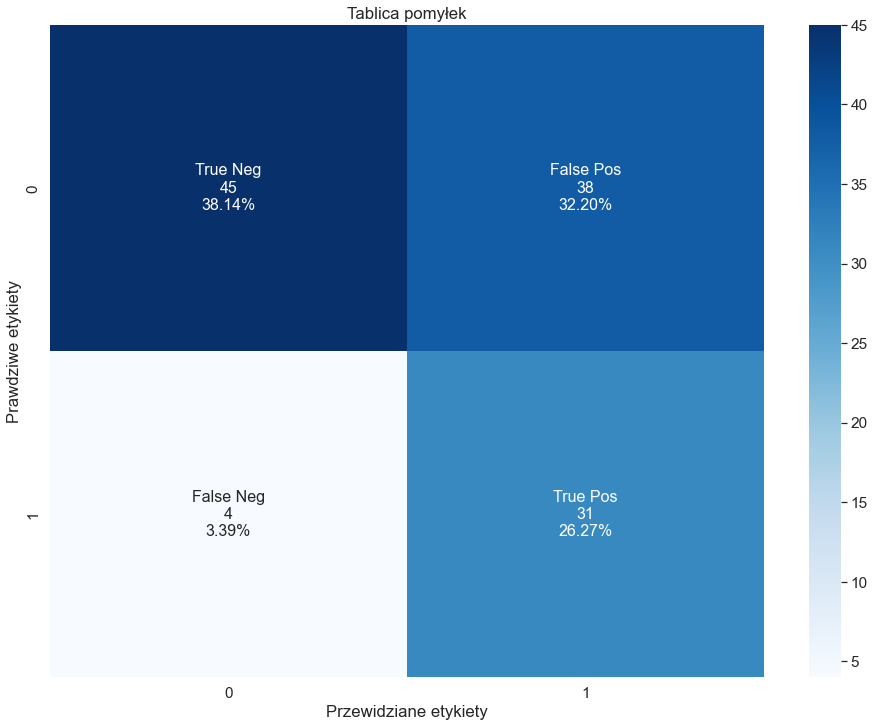

Accuracy for all: 79/118; 66.95%


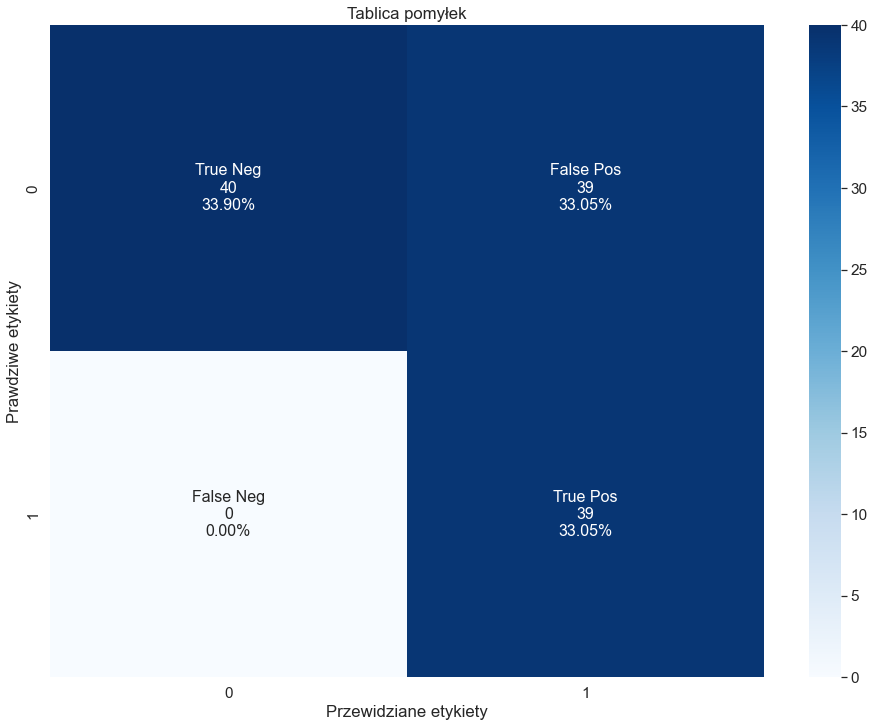

Accuracy for all: 76/118; 64.41%


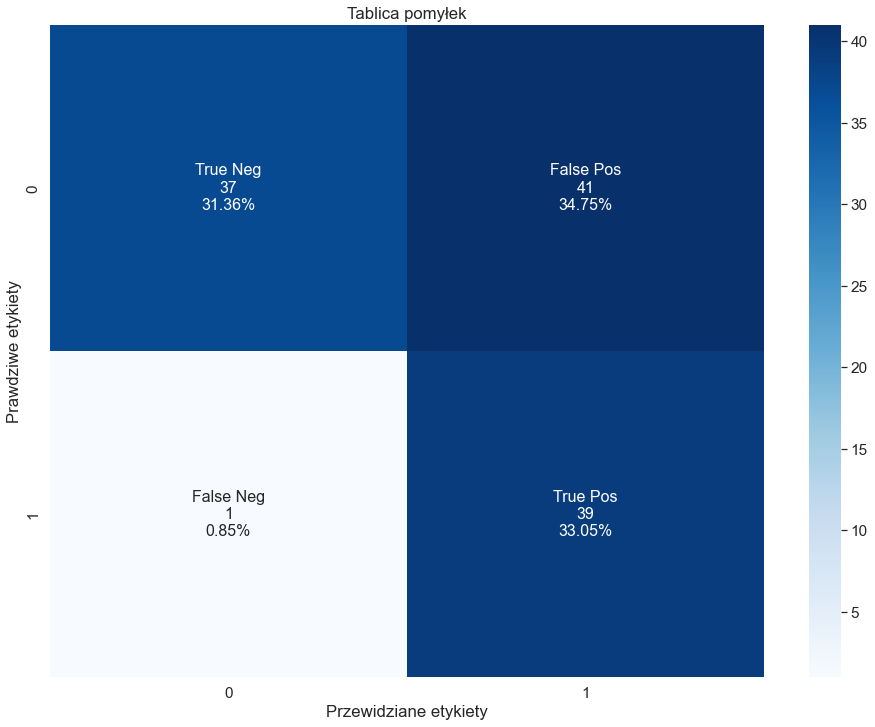

In [150]:
# Test działania Klasyfikatora rozmytego:
for _ in range(3):
    shuffled_data = ProcessingData.shuffle(cleared_data)
    _, validation_data = ProcessingData.split(shuffled_data, 0.7)

    # true negative
    tn = 0
    # false positive
    fp = 0
    # false negative
    fn = 0
    # true positive
    tp = 0

    # sprawdzenie dla każdej próbki w zbiorze walidacyjnym
    for _, value in validation_data.iterrows():
        # zapisanie wyniku i jego wartości liczbowej do zmiennych
        result = fuzzy.compute(value)[0]
        outcome = value['Outcome']

        # zliczenie przypadków
        if outcome == 0:
            if result == 'low':
                tn += 1
            elif result == 'high':
                fp += 1
        else:
            if result == 'high':
                tp += 1
            elif result == 'low':
                fn += 1

    # wyświetlenie dokładności
    print(f'Accuracy for all: {tn + tp}/{tn + fp + fn + tp}; {(tn + tp) / (tn + fp + fn + tp) * 100:0.2f}%')

    # Tworzenie tablicy pomyłek
    cf_matrix = np.array([[tn, fp],
                          [fn, tp]])
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = [f'{value:0.0f}' for value in cf_matrix.flatten()]
    group_percentages = [f'{value:.2%}' for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(16, 12))
    sns.set(font_scale=1.4)
    plot = sns.heatmap(cf_matrix, annot=labels, annot_kws={'size': 16}, fmt='', cmap='Blues')
    plot.set_title('Tablica pomyłek')
    plot.set_xlabel('Przewidziane etykiety')
    plot.set_ylabel('Prawdziwe etykiety')
    plt.show()